Importing Libraries

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib
from PIL import Image
import torch
from torch import nn
from torch import optim
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision.transforms import transforms
import torch.nn.functional as F
from tqdm import tqdm
from time import sleep


Loading the Dataset

In [4]:
folder_path='/kaggle/input/severstal-steel-defect-detection/'
images_path=folder_path+'train_images/'
tab=pd.read_csv(folder_path+'train.csv')
c=4
tab=tab[tab['ClassId']==c].copy()
tab=tab.reset_index().drop('index',axis=1)
images_list=tab['ImageId'].unique()
tab

ImageId  ClassId                                      EncodedPixels
0    000f6bf48.jpg        4  131973 1 132228 4 132483 6 132738 8 132993 11 ...
1    0025bde0c.jpg        4  315139 8 315395 15 315651 16 315906 17 316162 ...
2    002af848d.jpg        4  290800 6 291055 13 291311 15 291566 18 291822 ...
3    0030401a5.jpg        4  186833 1 187089 3 187344 6 187600 7 187855 10 ...
4    008621629.jpg        4  215548 3 215798 9 216051 12 216306 13 216560 1...
..             ...      ...                                                ...
796  fda1a539d.jpg        4  128621 3 128876 8 129131 11 129386 13 129641 1...
797  fdb7c0397.jpg        4  155020 6 155268 16 155516 27 155764 37 156012 ...
798  feec56162.jpg        4  99346 1 99602 1 99858 1 100113 2 100369 3 1006...
799  ff6bfada2.jpg        4  90877 2 91131 4 91385 6 91638 9 91892 12 92146...
800  ff9d46e95.jpg        4  326401 4 326658 9 326915 12 327172 13 327429 1...

[801 rows x 3 columns]

making a function that converts running pixels to 256 x 1600 matrix that shows the location of the defect in an image(fyi 0 is non defect pixel and 1 is defect pixel)

In [5]:
def pix_to_mat(pixels, h , w):
    p_list = pixels.split()
    start = np.array(p_list[0::2]).astype(int)
    length = np.array(p_list[1::2]).astype(int)
    n = len(start)
    m = np.zeros(h*w)
    for i in range(n):
        m[start[i] - 1 : start[i] - 1 + length[i]] = 1
    m = m.reshape(w,h).T
    return m

In [6]:
#Verification

h = 4
w = 5
pixels = '1 3 6 3 11 1 18 3'
pix_to_mat(pixels, h, w)

array([[1., 0., 0., 0., 0.],
       [1., 1., 0., 0., 1.],
       [1., 1., 1., 0., 1.],
       [0., 1., 0., 0., 1.]])

Number of Defect Pixels: 93452 out of 409600 pixels.


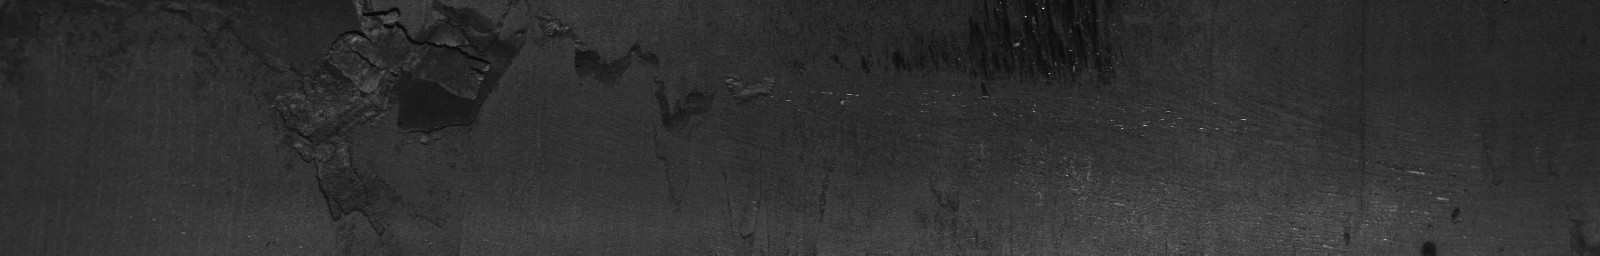

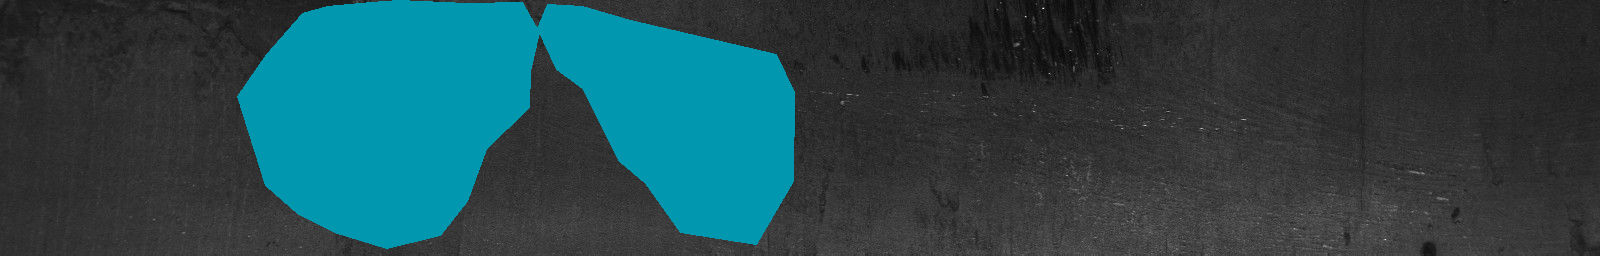

Number of Defect Pixels: 8670 out of 409600 pixels.


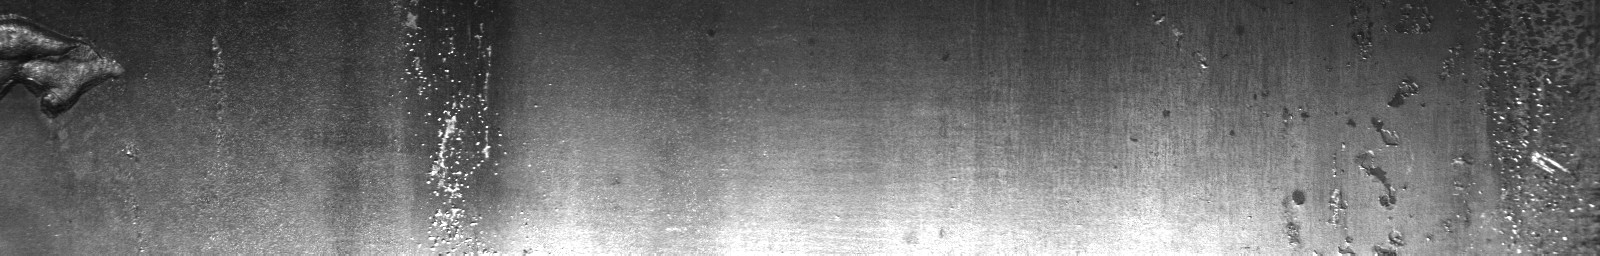

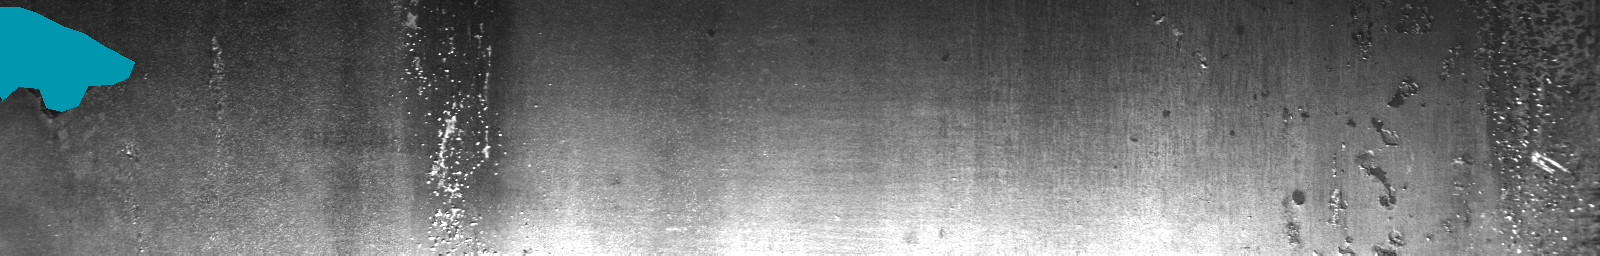

Number of Defect Pixels: 8739 out of 409600 pixels.


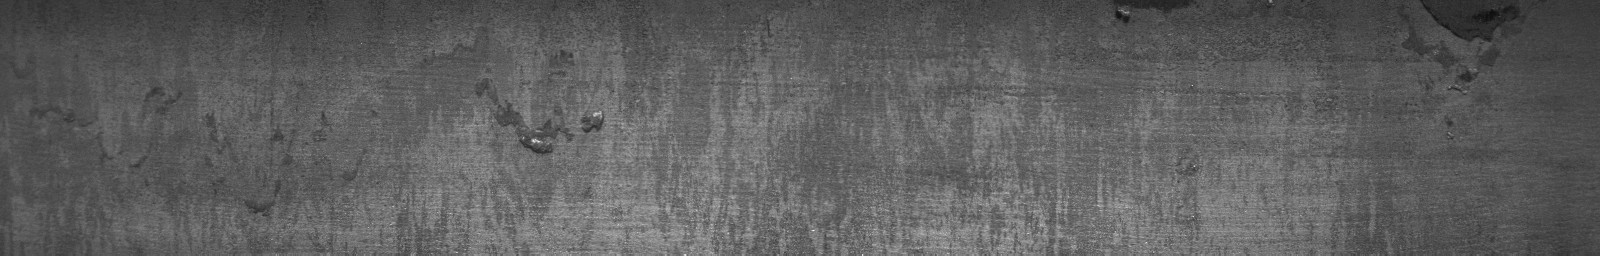

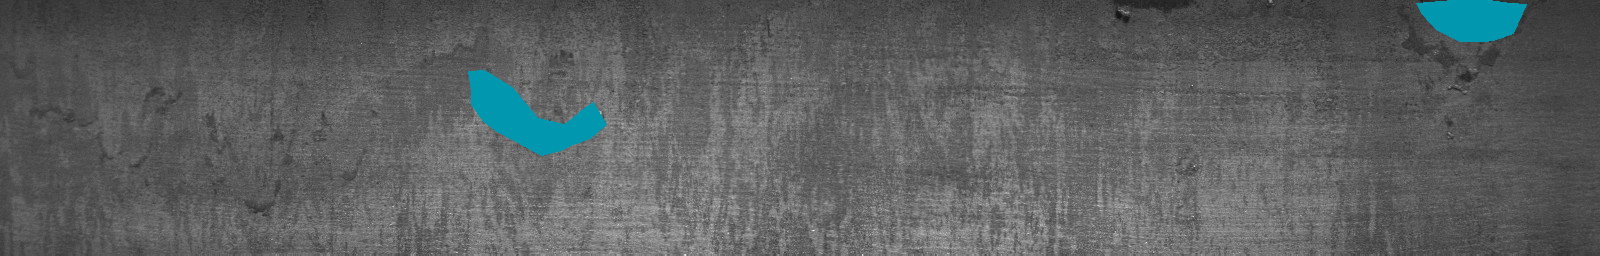

In [7]:
def image_show(imageid):
    pixels=tab[tab['ImageId']==imageid]['EncodedPixels'].item()
    image_mask=pix_to_mat(pixels,256,1600)
    img=mpimg.imread(images_path+imageid).transpose(-1,0,1).copy() # Make a copy here
    img[0,image_mask==1]=1
    img[1,image_mask==1]=152
    img[2,image_mask==1]=175
    print(f'Number of Defect Pixels: {round(image_mask.sum())} out of {256*1600} pixels.')
    display(Image.open(images_path+imageid))
    display(Image.fromarray(img.transpose(1,2,0)))

np.random.seed(45)
for i in range(3):
    imageid=np.random.choice(images_list)
    image_show(imageid)

In [8]:
np.random.seed(45)
print(len(images_list))
n=30
val=list(np.random.choice(images_list,n,replace=False))
train=list(set(images_list)-set(val))
test=list(np.random.choice(train,n,replace=False))
train=list(set(train)-set(test))
for l in train,val,test:
    print(len(l))
print(test[:2])

801
741
30
30
['24b29d740.jpg', 'a753532d6.jpg']


In [9]:
train_pos = []
valtest_pos = []

for i in range(0,32):
    train_pos.append(i * 40)
    
train_pos.append(1344)

for j in range(0,11):
    valtest_pos.append(j * 130)

valtest_pos.append(1344)

print(len(train_pos))
print(len(valtest_pos))

33
12


In [10]:
train_expanded = []
val_expanded = []
test_expanded = []

for imageid in train:
    pixels = tab[tab['ImageId'] == imageid]['EncodedPixels'].item()
    image_mask = pix_to_mat(pixels, 256, 1600)
    
    for p in train_pos:
        
        if image_mask[:,p:p+256].sum() > 12000:
            
            train_expanded.append(imageid + '_' + str(p))
            
for imageid in val:
    pixels = tab[tab['ImageId'] == imageid]['EncodedPixels'].item()
    image_mask = pix_to_mat(pixels, 256, 1600)
    
    for p in valtest_pos:
        
        if image_mask[:,p:p+256].sum() > 5000:
            
            val_expanded.append(imageid + '_' + str(p))

for imageid in test:
    pixels = tab[tab['ImageId'] == imageid]['EncodedPixels'].item()
    image_mask = pix_to_mat(pixels, 256, 1600)
    
    for p in valtest_pos:
        
        if image_mask[:,p:p+256].sum() > 5000:
            
            test_expanded.append(imageid + '_' + str(p))
            
print(len(train_expanded))
print(len(val_expanded))
print(len(test_expanded))

4704
109
110


In [11]:
MEAN =  99.45881939063021
STD =  50.285401061795476

t1 = transforms.ToTensor()
vf = transforms.RandomVerticalFlip()
hf = transforms.RandomHorizontalFlip()

class data(Dataset):
    
    def __init__(self, list_expanded, data_type): 
                    #data_type: 'train', 'val', or 'test.
        
        self.list_expanded = list_expanded
        self.data_type = data_type
    
    def __len__(self):
        
        return len(self.list_expanded)
    
    def __getitem__(self, idx):
        
        imageid = self.list_expanded[idx].split('_')[0]
        p =  int(self.list_expanded[idx].split('_')[1])
        image = Image.open(images_path + imageid)

        m = MEAN/255
        s = STD/255

        t2 = transforms.Normalize(mean = m , std = s)

        img_tensor = t2(t1(image)[0].unsqueeze(0))

        X_ = img_tensor[:, :, p : p + 256]

        pixels = tab[tab['ImageId'] == imageid]['EncodedPixels'].item()
        image_mask = pix_to_mat(pixels, 256, 1600)
        y_ = torch.tensor(image_mask).unsqueeze(0)[:, :, p : p + 256]
        
        if self.data_type == 'train':
            
            if np.random.randint(1,3) == 1:
                X_ = vf(X_)  
                y_ = vf(y_)

            if np.random.randint(1,3) == 1:
                X_ = hf(X_)
                y_ = hf(y_)

        return X_, y_

torch.manual_seed(6)
    
traindata = data(train_expanded, 'train')
valdata = data(val_expanded, 'val')
testdata = data(test_expanded, 'test') 

trainloader = DataLoader(traindata, batch_size = 16, shuffle = True)
valloader = DataLoader(valdata, batch_size = len(val_expanded))
testloader = DataLoader(testdata, batch_size = len(test_expanded))

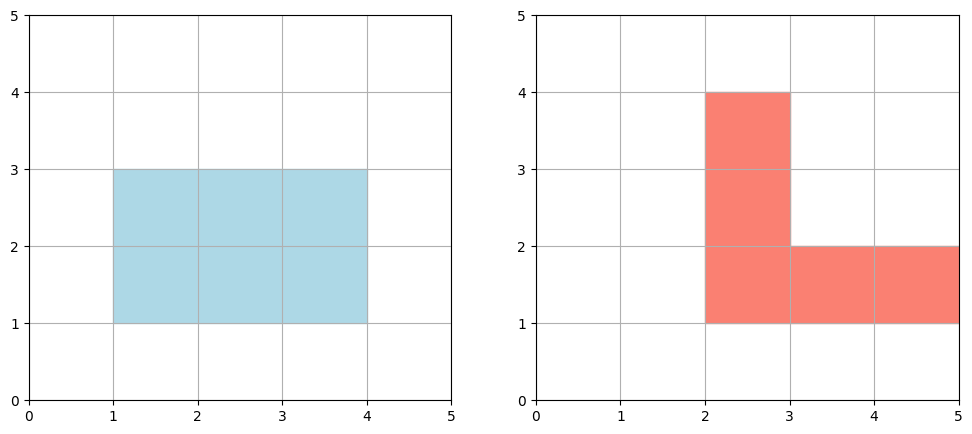

In [12]:
fig, axes = plt.subplots(1, 2, figsize = (12, 5))

for i in range(2):
    axes[i].set_xlim(0, 5)
    axes[i].set_ylim(0, 5)
    axes[i].grid(True)

axes[0].plot()
rect1 = matplotlib.patches.Rectangle((1,1), 3, 2, color='lightblue')
rect2 = matplotlib.patches.Rectangle((2,1), 1, 3, color='salmon')
rect3 = matplotlib.patches.Rectangle((3,1), 2, 1, color='salmon')
axes[0].add_patch(rect1)
axes[1].add_patch(rect2)
axes[1].add_patch(rect3)
plt.show()

In [13]:
class DiceBCELoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(DiceBCELoss, self).__init__()

    def forward(self, inputs, targets, smooth=1): 
        
        #flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        
        intersection = (inputs * targets).sum()                            
        dice_loss = 1 - (2.*intersection + smooth)/(inputs.sum() + targets.sum() + smooth)  
        BCE = F.binary_cross_entropy(inputs, targets, reduction='mean')
        Dice_BCE = BCE + dice_loss
        
        return Dice_BCE

In [14]:
if torch.cuda.is_available():
    device = 'cuda'
    
print(device)

class DoubleConvs(nn.Module):
    
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.ic = in_channels
        self.oc = out_channels
        self.conv1 = nn.Conv2d(self.ic, self.oc, kernel_size = 3, padding = 1) 
        self.relu1 = nn.ReLU()
        self.conv2 = nn.Conv2d(self.oc, self.oc, kernel_size = 3, padding = 1) 
        self.relu2 = nn.ReLU()
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.conv2(x)
        x = self.relu2(x)
        
        return x

class UNet(nn.Module):
    
    def __init__(self):
        
        super().__init__()
        
        self.cs = [1,32,64,128,256,512]
        self.DownConvs = nn.ModuleList(DoubleConvs(self.cs[i],self.cs[i+1]) for i in range(4))
        self.DownPools = nn.ModuleList(nn.MaxPool2d(kernel_size = 2, stride = 2) for i in range(4))
        self.Bottleneck = DoubleConvs(256,512)
        self.UpConvs = nn.ModuleList(DoubleConvs(self.cs[i], self.cs[i-1]) for i in range(5,1,-1))
        self.Ups = nn.ModuleList(nn.ConvTranspose2d(self.cs[i], self.cs[i-1], kernel_size = 2, stride = 2) for i in range(5,1,-1))
        self.FinalConv = nn.Conv2d(32, 1, kernel_size = 3, padding = 1)
        self.Sigmoid = nn.Sigmoid()
        
    def forward(self, x):
        
        skip_connections = []
            
        for i in range(4):
            x = self.DownConvs[i](x)
            skip_connections.append(x)
            x = self.DownPools[i](x)
            
        x = self.Bottleneck(x)
        
        skip_connections.reverse()
        
        for i in range(4):
            x = self.Ups[i](x)
            x = torch.cat([x, skip_connections[i]], dim = 1)
            x = self.UpConvs[i](x)
        
        x = self.FinalConv(x)
        x = self.Sigmoid(x)
        
        return x

torch.manual_seed(5)
model = UNet().to(device)

loss_fn = DiceBCELoss()

learning_rate = 0.0001
optimizer = optim.Adam(model.parameters(), lr = learning_rate)

W = [k for k in model.state_dict().keys() if '.weight' in k] #Convolution Weights
B = [k for k in model.state_dict().keys() if '.bias' in k] #Convolution Biases

for w in W:
    nn.init.kaiming_uniform_(model.state_dict()[w], a=0, mode='fan_in', nonlinearity='relu')
    
for b in B:
    nn.init.zeros_(model.state_dict()[b])

cuda


In [15]:
def overfit_minibatch():

    model.train()

    X, y = next(iter(trainloader))
    X, y = X.to(device)[0].unsqueeze(0), y.to(torch.float32).to(device)[0].unsqueeze(0)

    for i in tqdm(range(1000)):
        y_pred = model(X)
        loss = loss_fn(y_pred, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if (i+1) % 100 == 0:
            sleep(0.5)
            print(loss.item())
            
def validation(th): #th is the threshold for getting the binary output (1:defect, 0:no defect)

    V_dice = 0

    X, y = next(iter(valloader))

    model.eval()

    with torch.no_grad():

        for n in range(len(valdata)):
            
            y_pred = model(X[n].unsqueeze(0).to(device))
            m1 = y[n].numpy().squeeze()
            m2 = 1 * (y_pred.cpu().numpy().squeeze() >= th)
            v_dice = 2*(m1 * m2).sum()/(m1.sum() + m2.sum())
            V_dice += v_dice
            
    model.train()

    return V_dice / len(valdata)

def test(th):

    T_dice = 0

    X, y = next(iter(testloader))

    model.eval()

    with torch.no_grad():

        for n in range(len(testdata)):
            
            y_pred = model(X[n].unsqueeze(0).to(device))
            m1 = y[n].numpy().squeeze()
            m2 = 1 * (y_pred.cpu().numpy().squeeze() >= th)
            t_dice = 2*(m1 * m2).sum()/(m1.sum() + m2.sum())
            T_dice += t_dice

    return T_dice / len(testdata)

def train(epochs):
    
    model.train()
    
    for i in range(epochs):
        
        L = 0
        
        for batch, (X,y) in tqdm(enumerate(trainloader)):
            
            X, y = X.to(device), y.to(torch.float32).to(device)
            y_pred = model(X)
            loss = loss_fn(y_pred, y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            L += loss.item()
    
        train_loss = L/len(trainloader)
        val_dice = validation(0.5)
        print(f'epoch {i+1}, train_loss(dice-bce):{train_loss}, val_dice_coef:{val_dice}')

In [16]:
train(10)

294it [02:05,  2.35it/s]


epoch 1, train_loss(dice-bce):1.1425920613363487, val_dice_coef:0.6312958363599163


294it [02:06,  2.32it/s]


epoch 2, train_loss(dice-bce):1.0472671959270425, val_dice_coef:0.6690456017188535


294it [02:07,  2.30it/s]


epoch 3, train_loss(dice-bce):1.0285473843010104, val_dice_coef:0.6966831160787262


294it [02:07,  2.31it/s]


epoch 4, train_loss(dice-bce):1.0150372560332421, val_dice_coef:0.7145947286032185


294it [02:07,  2.31it/s]


epoch 5, train_loss(dice-bce):1.0115581242000165, val_dice_coef:0.6926063021104533


294it [02:07,  2.31it/s]


epoch 6, train_loss(dice-bce):1.0014820836839222, val_dice_coef:0.746387659835344


294it [02:07,  2.30it/s]


epoch 7, train_loss(dice-bce):0.9931956393783595, val_dice_coef:0.7371720470538733


294it [02:07,  2.30it/s]


epoch 8, train_loss(dice-bce):0.9853707699954104, val_dice_coef:0.711482585935623


294it [02:07,  2.31it/s]


epoch 9, train_loss(dice-bce):0.9801596030086076, val_dice_coef:0.7270095430592213


294it [02:07,  2.31it/s]


epoch 10, train_loss(dice-bce):0.9636047971086438, val_dice_coef:0.715981912430672


In [17]:
def val_test_show(val_test, th):
    
    if val_test == 'val':
        r = np.random.randint(0,len(val_expanded))
        imageid_p = val_expanded[r]
    
    if val_test == 'test':
        r = np.random.randint(0,len(test_expanded))
        imageid_p = test_expanded[r]
        
    imageid = imageid_p.split('_')[0]
    p = int(imageid_p.split('_')[1])
    image = Image.open(images_path + imageid)

    m = MEAN/255
    s = STD/255

    t2 = transforms.Normalize(mean = m , std = s)

    img_tensor = t2(t1(image)[0].unsqueeze(0))

    X_ = img_tensor[:, :, p : p + 256]

    pixels = tab[tab['ImageId'] == imageid]['EncodedPixels'].item()

    mask = pix_to_mat(pixels, 256, 1600)[:,p:p+256]

    model.eval()

    with torch.no_grad():
        y_pred = model(X_.unsqueeze(0).to(device))

    pred_mask = y_pred.cpu().numpy().squeeze()

    img_matrix = (mpimg.imread(images_path+imageid).transpose(-1,0,1)[:,:, p : p +256].transpose(1,2,0))

    img_y = img_matrix.copy()
    img_y = img_y.transpose(-1,0,1)
    img_y[0, mask == 1] = 85
    img_y[1, mask == 1] = 213
    img_y[2, mask == 1] = 90
    img_y = img_y.transpose(1,2,0)

    img_pred = img_matrix.copy()
    img_pred = img_pred.transpose(-1,0,1)
    img_pred[0, pred_mask >= th] = 63
    img_pred[1, pred_mask >= th] = 107
    img_pred[2, pred_mask >= th] = 208
    img_pred = img_pred.transpose(1,2,0)
    
    pred = 1 * (pred_mask >= th)
    dice = 2 * (pred * mask).sum() / (pred.sum() + mask.sum())
    print(f'Dice Coefficient: {dice}')

    display(Image.fromarray(img_matrix))
    display(Image.fromarray(img_y))
    display(Image.fromarray(img_pred))

In [18]:
test(0.5)

0.7037412752091752

Dice Coefficient: 0.9323675068371646


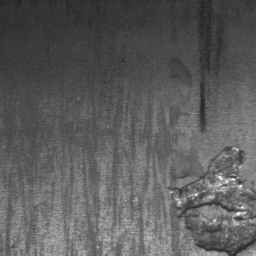

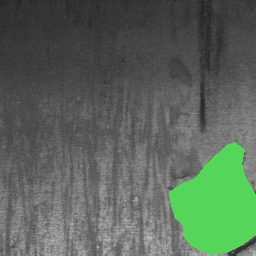

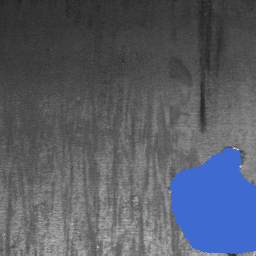

Dice Coefficient: 0.8786189112707423


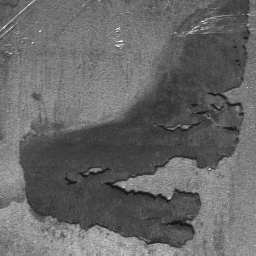

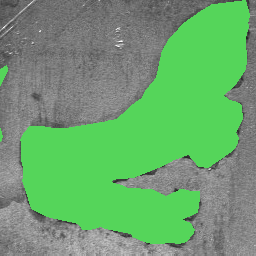

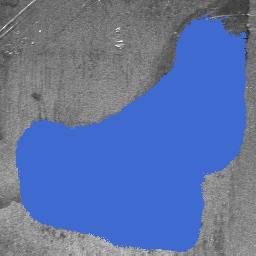

Dice Coefficient: 0.9117712896933261


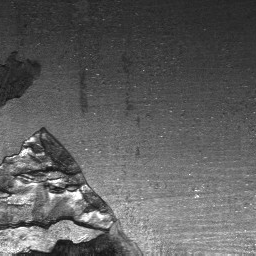

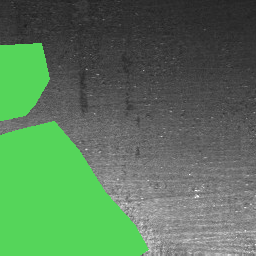

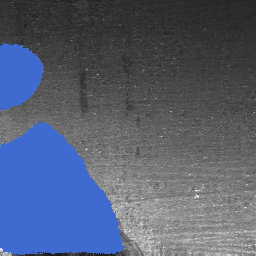

Dice Coefficient: 0.8538091302445427


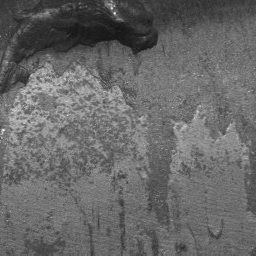

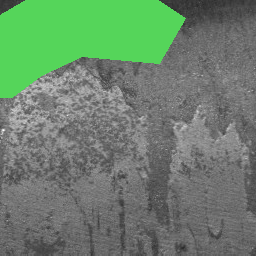

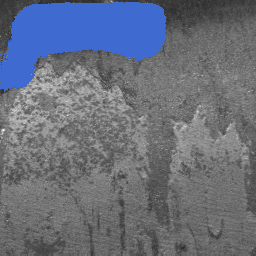

Dice Coefficient: 0.22634159446571295


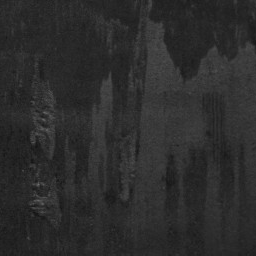

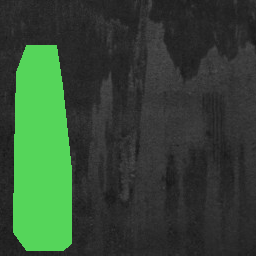

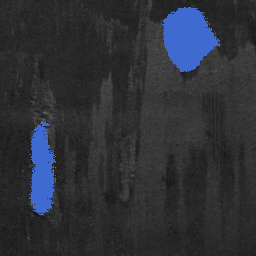

Dice Coefficient: 0.8623393213572854


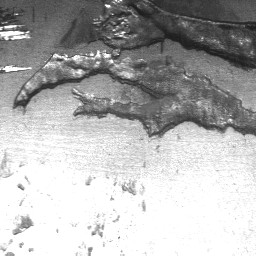

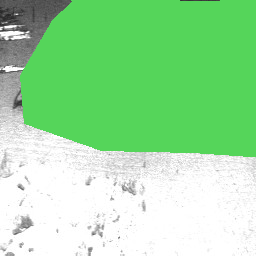

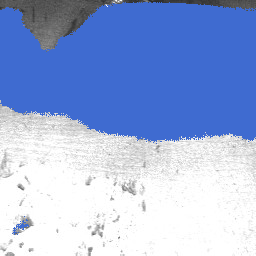

Dice Coefficient: 0.8275089605734767


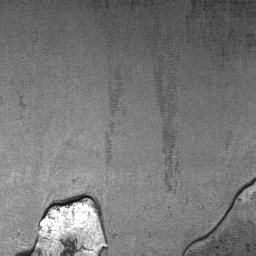

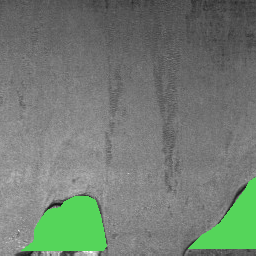

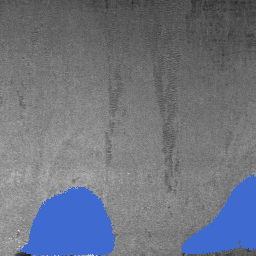

In [19]:
for i in range(7):
    val_test_show('test',0.5)

In [20]:
def evaluate_model(model, dataloader, threshold=0.5, device='cuda'):
    model.eval()
    total_correct = 0
    total_pixels = 0
    dice_total = 0.0
    iou_total = 0.0
    count = 0
    with torch.no_grad():
        for X, y in dataloader:
            X = X.to(device)
            y = y.to(device)
            outputs = model(X)
            preds = (outputs >= threshold).float()
            
            # Pixel accuracy
            total_correct += (preds == y).sum().item()
            total_pixels += y.numel()
            
            # Compute dice and IoU for each image in the batch
            # (summing over channels, height, and width)
            batch_size = X.size(0)
            preds_flat = preds.view(batch_size, -1)
            y_flat = y.view(batch_size, -1)
            intersection = (preds_flat * y_flat).sum(dim=1)
            union = (preds_flat + y_flat).sum(dim=1) - intersection
            dice = (2 * intersection + 1) / (preds_flat.sum(dim=1) + y_flat.sum(dim=1) + 1)
            iou = (intersection + 1) / (union + 1)
            
            dice_total += dice.sum().item()
            iou_total += iou.sum().item()
            count += batch_size
    
    pixel_accuracy = 100.0 * total_correct / total_pixels
    mean_dice = dice_total / count
    mean_iou = iou_total / count
    return pixel_accuracy, mean_dice, mean_iou

# Example usage on your testloader:
pixel_acc, mean_dice, mean_iou = evaluate_model(model, testloader, threshold=0.5, device=device)
print(f"Pixel Accuracy: {pixel_acc:.2f}%")
print(f"Mean Dice Coefficient: {mean_dice:.4f}")
print(f"Mean IoU: {mean_iou:.4f}")

Pixel Accuracy: 88.13%
Mean Dice Coefficient: 0.7038
Mean IoU: 0.5841
